# Deep Q-Network Code Walkthrough in MLX

In this video, we're going to implement a classic paper from all the way back from 2013.

I'm going to assume you have some level of famililarity with neural network concepts like convolutional neural networks and fully-connected layers, but 



Neural Network Reinforcement Learning system described in [Playing Atari with Deep Reinforcement Learning](playing-atari-with-deep-reinforcement-learning.md).

## ALE

The [[Arcade Learning Environment]] paper came out in 2012, and provided an evaluation set encouraging people to try reinforcement learning algorithms on Atari console games.

## DeepMind

 Hassabis and Legg first met at the Gatsby Computational Neuroscience Unit at University College London (UCL), where they were interested in building general purpose AIs that could beat video games.

### CNN

A year earlier, a research team had taken LeCunn's CNNs, and trained it on ImageNet, to demonstrate the capacity of CNNs to reason from raw image pixels.

Now you have the team attempting to demonstrate that you can take this idea of Q-Learning, but instead of a recursive algorithm you can use a neural entwork trained on raw pixel frames to predict next action, to maximise rewards.

## Architecture

I'm going to write [Deep Q-Network](deep-q-network.md) model from scratch using MLX.

DQN is a historical algorithm for reinforcement learning, that was one of the pioneer of the utilisation of neural networks in reinforcement learning.

The describe it as:

"""
The input to the neural network consists is an 84 × 84 × 4 image produced by φ.

The first hidden layer convolves 16 8 × 8 filters with stride 4 with the input image and applies a rectifier nonlinearity [10, 18].

The second hidden layer convolves 32 4 × 4 filters with stride 2, again followed by a rectifier nonlinearity.

The final hidden layer is fully-connected and consists of 256 rectifier units.

The output layer is a fully-connected linear layer with a single output for each valid action.

The number of valid actions varied between 4 and 18 on the games we considered.

We refer to convolutional networks trained with our approach as Deep Q-Networks (DQN).
"""

So let's build that in MLX. I'm a bit new to MLX, but I'm interested in learning it, so this video is kind of going to be me learning it with you.

The idea of DQN is that an agent gets the next action to take from a neural network.

The network they build is a convolutional layer network network with only 2 conv layers and a hidden layer.

So they have an input of batch, img height, img width, frames

In [1]:
import mlx.core as mx

batch_size = 32
input = mx.random.normal((batch_size, 84, 84, 4))
input.shape
# (32, 84, 84, 4)

(32, 84, 84, 4)


The nn package in mlx contains a bunch of useful neural network implementations, including a convolution. 

So we can implement the first convolutional layer, it is a : "first hidden layer convolves 16 8 × 8 filters with stride 4 with the input image and applies a rectifier nonlinearity"

In [2]:
import mlx.nn as nn

# Define the first convolutional layer
conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4)
relu = nn.relu
hidden1 = relu(conv1(input))
hidden1.shape
# (32, 20, 20, 16)

(32, 20, 20, 16)

The gives us a 20x20 shape with 16 channels. The next layer:

The second hidden layer convolves 32 4 × 4 filters with stride 2, again followed by a rectifier nonlinearity. 

In [3]:
conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)
hidden2 = relu(conv2(hidden1))
hidden2.shape
# (32, 9, 9, 32)

(32, 9, 9, 32)


Then they flatten that, and pass it into a linear layer:

The final hidden layer is fully-connected and consists of 256 rectifier units.

In [4]:
9 * 9 * 32

2592

In [5]:
hidden3 = hidden2.reshape(batch_size, -1)
hidden3.shape
(32, 2592)

(32, 2592)

In [6]:
fc1 = nn.Linear(input_dims=2592, output_dims=256)
hidden3 = fc1(hidden3)
hidden3.shape
# (32, 256)

(32, 256)

The output layer is a fullyconnected linear layer with a single output for each valid action.

In [7]:
# Pacman has 4 valid actions.
num_actions = 5

fc2 = nn.Linear(input_dims=256, output_dims=num_actions)
out = fc2(hidden3)
out.shape
# (32, 4)

(32, 5)

So that's the simple version of the architecture. I've seen a lot of implementations online that add another convolutional layer.

Here is is all together:

In [8]:
import mlx.core as mx
import mlx.nn as nn

class DQN(nn.Module):
    def __init__(self, num_actions: int):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=4, out_channels=16, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=4, stride=2)

        self.fc1 = nn.Linear(2592, 256)  # 9x9x32 = 2592
        self.fc2 = nn.Linear(256, num_actions)

    def __call__(self, x):
        x = nn.relu(self.conv1(x))  # (batch, 84, 84, 4) → (batch, 20, 20, 16)
        x = nn.relu(self.conv2(x))  # → (batch, 9, 9, 32)
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)        # → (batch, 2592)
        x = nn.relu(self.fc1(x))    # → (batch, 256)
        x = self.fc2(x)             # → (batch, num_actions)
        return x


batch_size = 32
num_actions = 5
input = mx.random.normal((batch_size, 84, 84, 4))

model = DQN(num_actions)
output = model(input)
print(output.shape)  # (32, 4)

(32, 5)


### Dataset

OpenAI released a library called gym, which was discontinued, but another community library gynamisum provides a compatbile API, and yet another library called ale_py that now has all the Atari game ROMs.

I'm going to load the PacMan. It was one of the games tested in the paper, and the player is limited to 5 actions: nothing, up, right, left, down.

In [9]:
import gymnasium as gym
import ale_py

env = gym.make("ALE/Pacman-v5")

A.L.E: Arcade Learning Environment (version 0.11.0+dfae0bd)
[Powered by Stella]


An Env is a class that provides a helpful game wrapper.

We can see available actions:

In [10]:
env.action_space.n

np.int64(5)

There's a few methods we're interested in: reset and step

which resets the env. It gives us two objects. The observation, which is a numpy array containing a graphical representation of the game. 

In [11]:
observation, info = env.reset()
observation.shape
# (210, 160, 3)

(250, 160, 3)

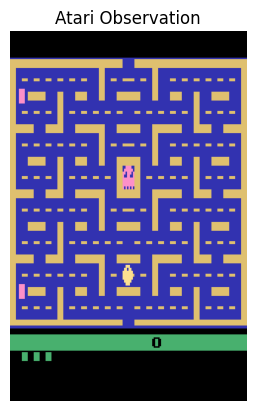

In [12]:
from matplotlib import pyplot as plt

plt.imshow(observation)
plt.title("Atari Observation")
plt.axis("off")
plt.imsave("observation.png", observation)

And step, which takes an action in the game. For example, let me move right one. It also returns the next observation after taking that step, as well as a reward, a bool as to wheter it was terminated, antoher bool for truncated (maybe the game went to long), and a dict containing useful info.

In [13]:
right_action = 2
for i in range(10000):
    observation, reward, terminated, truncated, info = env.step(right_action)

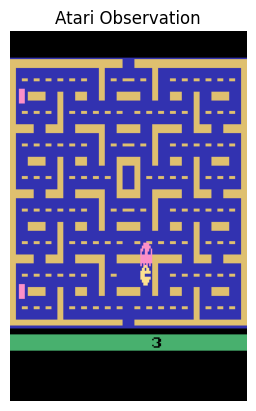

In [14]:
plt.imshow(observation)
plt.title("Atari Observation")
plt.axis("off")
plt.imsave("observation_after.png", observation)

With that in mind, we can write a simple loop that randomly walks through the game, until a done condition occurs, either we're terminated or truncated.

In [15]:
import gymnasium as gym
import ale_py
import random

env = gym.wrappers.RecordVideo(
    gym.make("ALE/Pacman-v5", render_mode="rgb_array"),
    video_folder="videos/",
    episode_trigger=lambda episode_id: True  # Record every episode
)

observation, info = env.reset()

done = False
while not done:
    action = random.choice(range(env.action_space.n))
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated

env.close()

/Users/lex/code/deep-q-network-mlx/.venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/lex/code/deep-q-network-mlx/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


In [16]:
from IPython.display import Video

In [17]:
!ls -l videos/

total 896
-rw-r--r--@ 1 lex  staff   52441  5 May 07:50 rl-video-episode-0.mp4
-rw-r--r--@ 1 lex  staff    4292  4 May 15:30 rl-video-episode-1.mp4
-rw-r--r--@ 1 lex  staff   50260  4 May 15:36 rl-video-episode-10.mp4
-rw-r--r--@ 1 lex  staff   23386  4 May 15:42 rl-video-episode-11.mp4
-rw-r--r--@ 1 lex  staff    4292  4 May 15:30 rl-video-episode-2.mp4
-rw-r--r--@ 1 lex  staff    4292  4 May 15:32 rl-video-episode-3.mp4
-rw-r--r--@ 1 lex  staff    4825  4 May 15:33 rl-video-episode-4.mp4
-rw-r--r--@ 1 lex  staff    4825  4 May 15:33 rl-video-episode-5.mp4
-rw-r--r--@ 1 lex  staff    4825  4 May 15:33 rl-video-episode-6.mp4
-rw-r--r--@ 1 lex  staff  176953  4 May 15:34 rl-video-episode-7.mp4
-rw-r--r--@ 1 lex  staff   84074  4 May 15:34 rl-video-episode-8.mp4
-rw-r--r--@ 1 lex  staff    8430  4 May 15:35 rl-video-episode-9.mp4


In [18]:
Video("videos/rl-video-episode-0.mp4")

## Preprocessing

The preprocessing from the paper is 

> The raw frames are preprocessed by first converting their RGB representation to gray-scale and down-sampling it to a 110×84 image. The final input representation is obtained by cropping an 84 × 84 region of the image that roughly captures the playing area.

This comes available to us in the gymnasium wrappers.

In [19]:
from gymnasium.wrappers import AtariPreprocessing

In [20]:
env = gym.make("ALE/Pacman-v5", frameskip=1)
env = AtariPreprocessing(env)

In [21]:
obs, _ =  env.reset()
obs.shape

(84, 84)

They use a stack of 4 frames for each observation.

In [22]:
from gymnasium.wrappers import FrameStackObservation

# From the docs: "Stacks the observations from the last ``N`` time steps in a rolling manner.""
env = FrameStackObservation(env, stack_size=4)

In [23]:
obs, _ =  env.reset()
obs.shape

(4, 84, 84)

After that, one last thing I'll do is apply a transform to change the dimensions from channels, height widht, to height, width, channels, as that's how MLX neural network library expects things, and also convert it from int to float, by dividing by the max int value 255.

In [24]:
from gymnasium.wrappers import TransformObservation

env = TransformObservation(env, lambda obs: obs.transpose(1,2,0) / 255., env.observation_space)
obs, _ =  env.reset()
obs.shape, obs.dtype

((84, 84, 4), dtype('float64'))

### Experience Replay



### Training

Firstly, the introduce a concept called **Experience Replay Buffers**, they store an agents experience's at each time-step, $e_t = (s_t, a_t, r_t, s_{t+1})$

> we utilize a technique known as experience replay [13] where we store the agent’s experiences at each time-step, et = (st, at, rt, st+1)
in a data-set D = e1, ..., eN , pooled over many episodes into a replay memory. During the inner
loop of the algorithm, we apply Q-learning updates, or minibatch updates, to samples of experience,
e ∼ D, drawn at random from the pool of stored samples.

I'll use a named tuple to create an experience instance.

In [25]:
from typing import List
from collections import namedtuple
from pydantic import BaseModel

Experience = namedtuple('Experience', ['state', 'action', 'reward', 'state_next', 'done'])
experience_replay: List[Experience] = []

Now, for some number of episodes $M$, we're going to step through the game, either randomly performing actions, or sampling the action reward with the highest predicted score from the network.

However, just randomly selection actions, means that the model may never find the optimial actions to take. Instead what we do is allow it to go random for half the episode, then gradually select optimal actions using the trained model.

The probability of taking a random action decays, until eventaully we're only taking random choices 10% of the time.

We also build our experience_replay buffer as  wel go.

In [26]:
# Configuration paramaters for the whole setup
seed = 42
gamma = 0.99  # Discount factor for past rewards
epsilon = 1.0  # Epsilon greedy parameter
epsilon_min = 0.1  # Minimum epsilon greedy parameter
epsilon_max = 1.0  # Maximum epsilon greedy parameter
epsilon_interval = (
    epsilon_max - epsilon_min
)  # Rate at which to reduce chance of random action being taken
batch_size = 32  # Size of batch taken from replay buffer
max_steps_per_episode = 10000
frame_count = 0

In [27]:
M = 10000
max_steps_per_episode = 10000
# Number of frames for exploration
epsilon_greedy_frames = 1000000.0
# Number of frames to take random action and observe output
epsilon_random_frames = 50000

for episode_num in range(2):
    # Initialise episode
    state, info = env.reset()

    # Convert to float
    state = mx.array(state) / 255.

    episode_reward = 0
    
    for i in range(max_steps_per_episode):
        frame_count += 1
        if frame_count < epsilon_random_frames or epsilon > mx.random.uniform().item():
            action = mx.random.randint(0, env.action_space.n).item()
        else:
            action = mx.argmax(model(mx.expand_dims(state, 0))).item()
            
        epsilon -= epsilon_interval / epsilon_greedy_frames
        epsilon = max(epsilon, epsilon_min)
        
        # Apply the sampled action in our environment
        state_next, reward, terminated, truncated, info = env.step(action)
        
        state_next = mx.array(state_next) / 255.
        
        episode_reward += reward
        done = terminated or truncated
        experience_replay.append(
            Experience(
                state=state,
                action=action,
                reward=reward,
                state_next=state_next,
                done=done))
                
        state = state_next

        if done:
            break

In [28]:
state.shape

(84, 84, 4)

In [29]:
state.shape

(84, 84, 4)

In [30]:
mx.expand_dims(state, -1).shape

(84, 84, 4, 1)

In [31]:
state.shape

(84, 84, 4)

Now the really interesting part. Even 4 steps, we sample from our experience replay buffer. We take a sample of a mini batch of states, along with the action taken, reward, and next state.

I'll firstly get a batch size of random indicies.

In [32]:
indices = mx.random.randint(0, len(experience_replay), shape=(batch_size,))
indices = list(int(i) for i in indices)

Now to fetch those corresponding experiences, "done" values, actions and rewards.

In [33]:
experience_sample = [experience_replay[i] for i in indices]
done_sample = mx.array([experience_replay[i].done for i in indices])
action_sample = mx.array([experience_replay[i].action for i in indices])
rewards_sample = mx.array([experience_sample[i].reward for i in range(len(indices))])
state_sample = mx.array([experience_sample[i].state for i in range(len(indices))])
experience_sample[0].state.shape

(84, 84, 4)

In [34]:
list(done_sample)

[array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool),
 array(False, dtype=bool)]

We fetch the estimated rewards using our model.

In [35]:
future_rewards = model(mx.expand_dims(state_next, 0))
future_rewards.shape

(1, 5)

For the "ground-truth" label, we take the actual reward from that step, and add to the expected future reward, multipled by a discount factor.

In [36]:
# Q value = reward + discount factor * expected future reward
ground_truth_q_values = rewards_sample + gamma * mx.max(future_rewards, axis=1)
ground_truth_q_values.shape

(32,)

In [37]:
done_sample

array([False, False, False, ..., False, False, False], dtype=bool)

In [38]:
# If final frame set the last value to -1
ground_truth_q_values = ground_truth_q_values * (1 - done_sample) - done_sample

In [40]:
done_sample.shape

(32,)

To calculate the loss, we calculate the expected reward from the 

In [41]:
masks = mx.eye(env.action_space.n)[action_sample]
masks.shape

(32, 5)

In [42]:
masks

array([[0, 0, 0, 0, 1],
       [0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0]], dtype=float32)

In [43]:
state_sample =  mx.array([experience_replay[i].state for i in indices])
state_sample.shape

(32, 84, 84, 4)

In [44]:
q_values = model(state_sample)
q_values.shape

(32, 5)

In [45]:
q_action = mx.sum(q_values * masks, axis=1)

In the paper, the loss function is Huber loss.

In [46]:
from mlx.nn.losses import huber_loss
import mlx.nn as nn
from mlx import optimizers as optim

In [47]:
huber_loss

<function mlx.nn.losses.huber_loss(inputs: mlx.core.array, targets: mlx.core.array, delta: float = 1.0, reduction: Literal['none', 'mean', 'sum'] = 'none') -> mlx.core.array>

In [48]:
def loss_fn(predictions, targets):
    return mx.mean(huber_loss(predictions, targets))

In [49]:
learning_rate = 0.00025
optimizer = optim.Adam(learning_rate=learning_rate)

In [50]:
# Define a loss function
def compute_loss(states, actions, targets):
    # Forward pass to get Q-values
    q_values = model(states)
    
    # Select the Q-values for the actions taken
    masks = mx.eye(env.action_space.n)[actions]
    q_action = mx.sum(q_values * masks, axis=1)
    
    # Compute Huber loss
    return mx.mean(huber_loss(q_action, targets))

# Create a function that returns loss and gradients
def loss_and_grad(params, states, actions, targets):
    model.update(params)
    return compute_loss(states, actions, targets)

# Create the gradient function
grad_fn = mx.value_and_grad(loss_and_grad)

# Optimization step - NOT compiled for now to avoid the item() issue
def train_step(states, actions, targets):
    # Get current parameters
    params = model.trainable_parameters()
    
    # Compute loss and gradients
    loss, grads = grad_fn(params, states, actions, targets)
    
    # Update parameters using optimizer
    optimizer.update(model, grads)
    
    # Return the loss value, not the compiled function
    return loss

In [51]:
next_q_values = model(state_sample)
max_next_q = mx.max(next_q_values, axis=1)
targets = rewards_sample + gamma * max_next_q * (1 - done_sample)

# Perform training step
loss = train_step(state_sample, action_sample, targets)
print(f"Loss: {float(loss)}")  # Convert to float instead of using item()

Loss: 0.0008162444573827088


In [ ]:
q_action = mx.sum(q_values * masks, axis=1)

In [ ]:
loss = step(ground_truth_q_values, q_action)